## A bit of prep..
To make sure you have all the libraries, run the following command in the `Anaconda Prompt`
```bash
conda install -c conda-forge geopandas decartes
```

to download the boundary layer needed for the map you can run the following code:
```python
import urllib.request

url = 'https://opendata.arcgis.com/datasets/2c5b8eb836c7475ba3b305106ac9dfc3_0.geojson'
urllib.request.urlretrieve(url, './data/bounderies.geojson')
```

# Let's Map!
We are going to need 2 data sources:
* **Implementation date data**: in the *UCimplem.csv* (souce: Department for Work and Pensions)
* **Geolocated boundery file for all local authorities**: Can be downloaded from the Office for National Statistics: https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2016-boundaries (we have downloaded the ultra generalised layer)

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from filled_out.compatibility import ensure_mutipoly
%matplotlib inline

#### Implementation Data Loading

In [4]:
# load 'data/UCimplem.csv'
df = pd.read_csv('data/UCimplem.csv')
df.head(2)

,Country,Province,Code,County,UC implem
0,United Kingdom,England,E06000001,Hartlepool,Mar-15
1,United Kingdom,England,E06000002,Middlesbrough,Nov-15


In [5]:
# describe the dataset
df.describe()

,Country,Province,Code,County,UC implem
count,380,380,380,380,380
unique,1,3,380,380,34
top,United Kingdom,England,E07000012,Three Rivers,May-15
freq,380,326,1,1,45


### Column renaming
The column name is misleading, the `County` are actually local authorities. Let's rename the colum!

In [7]:
# rename 'County' to 'LocalAuth'
df = df.rename(columns={'County':'LocalAuth'})

### Date parsing

In [8]:
df['UC implem'][0]

'Mar-15'

In [15]:
def date_parser(x):
    return pd.to_datetime(x, format='%b-%y').to_datetime64().astype(float)

# apply it to 'UC implem' and call 'UC_date_number
df['UC_date_number'] = df['UC implem'].apply(date_parser)

In [16]:
# check head, 2 rows
df.head(2)

,Country,Province,Code,LocalAuth,UC implem,UC_date_number
0,United Kingdom,England,E06000001,Hartlepool,Mar-15,1.425168e+18
1,United Kingdom,England,E06000002,Middlesbrough,Nov-15,1.446336e+18


### Boundary Layers Loading

In [17]:
# load 'data/bounderies.geojson' with geopandas's "read_file" method onto a variable called "gdf"
gdf = gpd.read_file('data/bounderies.geojson')
# check head, 2 rows
gdf.head(2)

,objectid,lad18cd,lad18nm,lad18nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
0,1,E06000001,Hartlepool,,447157,531476,-1.27023,54.6762,9.364074e+07,69780.416446,"MULTIPOLYGON (((-1.27025 54.72717, -1.27251 54..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.5447,5.387613e+07,42262.990135,"MULTIPOLYGON (((-1.23003 54.58411, -1.23432 54..."


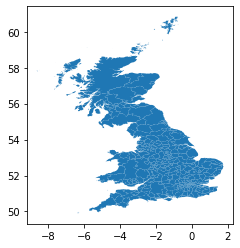

In [18]:
gdf.plot()

### Merging the data

In [19]:
merged_gdf = gdf.merge(
    right=df, 
    left_on='lad18cd', 
    right_on='Code',
)

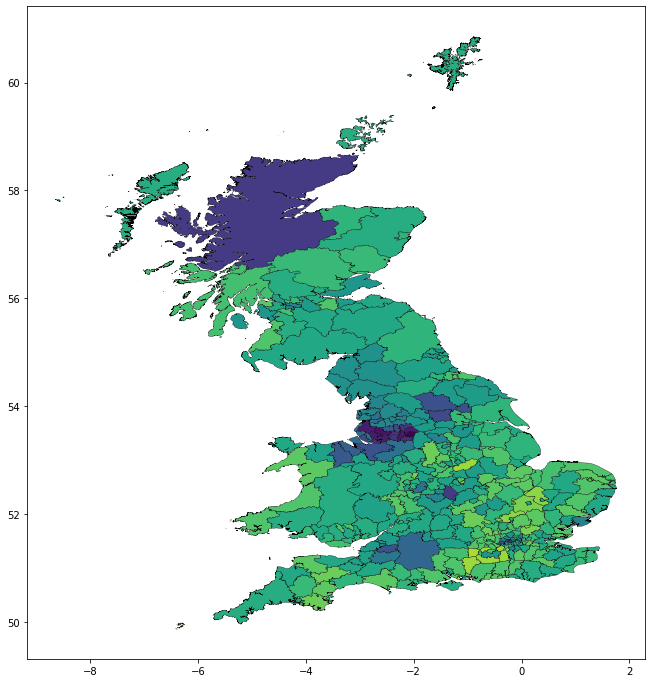

In [22]:
cmap = 'viridis'
ax = merged_gdf.plot(
    column='UC_date_number', 
    linewidth=0.3, edgecolor='black', 
    figsize=(18, 12), 
#     cmap=cmap,
)

# to change color select a different cmap from here: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html (default 'viridis')
# adding '_r' to the name uses the reversed colormap, e.g. 'Blues_r'

In [23]:
vmin = merged_gdf['UC_date_number'].min()
vmax = merged_gdf['UC_date_number'].max()
cbar_ticks_locations = pd.np.linspace(vmin, vmax, 8)
cbar_ticks_labels = [pd.Timestamp(i).strftime('%b-%y') for i in cbar_ticks_locations]

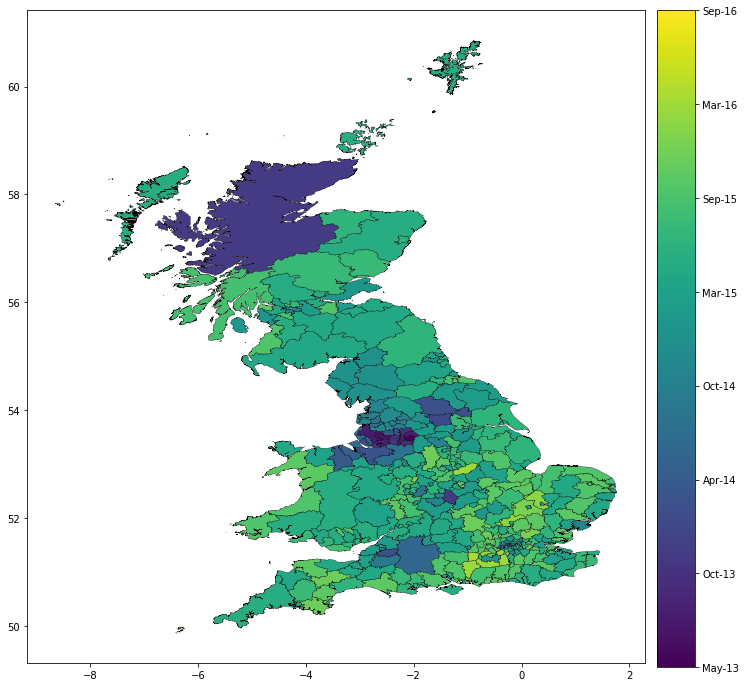

In [24]:
cbar = ax.figure.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
    cax=ax.figure.add_axes([0.76, 0.12, 0.03, 0.76]),  #[left, bottom, width, height] as fractions of figure width and height.
    ticks=cbar_ticks_locations
)
cbar.ax.set_yticklabels(cbar_ticks_labels)

ax.figure  # showing

### Save map as image

In [25]:
# save as image
ax.figure.savefig('static_map.png', dpi=300, bbox_inches='tight')  # dpi is to increase the resolution of the image (default 200)

### Save merged data for later

In [ ]:
useful_cols = ['Province', 'LocalAuth', 'UC implem', 'UC_date_number', 'geometry']
merged_gdf['geometry'] = ensure_mutipoly(merged_gdf['geometry'])
merged_gdf[useful_cols].to_file("data/map_data.geojson", driver='GeoJSON')